In [1]:
!pip install datasets transformers seqeval  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linu

In [2]:
from datasets import load_dataset
import torch
import numpy as np

# Load dataset
dataset = load_dataset("wikiann", "vi")

README.md: 0.00B [00:00, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/568k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/571k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [4]:
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer
)

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
# model = AutoModel.from_pretrained("vinai/phobert-base")


In [5]:
label_list = dataset["train"].features["ner_tags"].feature.names
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

In [6]:
from torch.utils.data import Dataset
import torch

class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        tokens = []
        label_ids = []

        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            label_ids.extend([label] + [-100] * (len(word_tokens) - 1))

        tokens = [self.tokenizer.cls_token] + tokens[:self.max_len - 2] + [self.tokenizer.sep_token]
        label_ids = [-100] + label_ids[:self.max_len - 2] + [-100]

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        pad_len = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * pad_len
        attention_mask += [0] * pad_len
        label_ids += [-100] * pad_len

        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label_ids)
        }

In [7]:
train_sentences = dataset["train"]["tokens"]
train_labels = dataset["train"]["ner_tags"]

val_sentences = dataset["validation"]["tokens"]
val_labels = dataset["validation"]["ner_tags"]

train_dataset = NERDataset(train_sentences, train_labels, tokenizer)
val_dataset = NERDataset(val_sentences, val_labels, tokenizer)


In [14]:
model = AutoModelForTokenClassification.from_pretrained(
    "vinai/phobert-base",
    # pretrained_model_name_or_path = "/kaggle/input/phobert_ner_cs221/other/default/1/phobert-ner/checkpoint-3125",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

In [15]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        temp_labels = []
        temp_preds = []
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                temp_labels.append(id2label[l_])
                temp_preds.append(id2label[p_])
        true_labels.append(temp_labels)
        true_preds.append(temp_preds)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }

In [16]:
args = TrainingArguments(
    output_dir="./phobert-ner",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_steps=100,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# trainer.train()

/tmp/ipykernel_35/118559268.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# validation

In [10]:
import numpy as np

print("Evaluation on validation set:")
metrics = trainer.evaluate()
print(metrics)

Evaluation on validation set:


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.18728040158748627, 'eval_precision': 0.9114381388790976, 'eval_recall': 0.9242248235188991, 'eval_f1': 0.917786947069524, 'eval_runtime': 52.0635, 'eval_samples_per_second': 192.073, 'eval_steps_per_second': 6.012, 'epoch': 5.0}


# test

In [35]:
test_sentences = dataset["test"]["tokens"]
test_labels = dataset["test"]["ner_tags"]

print(test_labels[0])  # kiểm tra phần tử đầu tiên
test_dataset = NERDataset(test_sentences, test_labels, tokenizer)

# Dự đoán (logits, labels)
pred_output = trainer.predict(test_dataset)
raw_preds = pred_output.predictions
raw_labels = pred_output.label_ids
predictions = np.argmax(raw_preds, axis=2)

true_labels = []
true_preds = []

for pred, label in zip(predictions, raw_labels):
    temp_true = []
    temp_pred = []
    for p_, l_ in zip(pred, label):
        if l_ != -100:
            temp_true.append(id2label[l_])
            temp_pred.append(id2label[p_])
    true_labels.append(temp_true)
    true_preds.append(temp_pred)

from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(true_labels, true_preds))
print("Precision:", precision_score(true_labels, true_preds))
print("Recall:", recall_score(true_labels, true_preds))
print("F1-score:", f1_score(true_labels, true_preds))


[5, 6, 0, 5, 6, 6, 6, 6]


Accuracy: 0.9580402358120277
Precision: 0.9062636498645933
Recall: 0.9176470588235294
F1-score: 0.9119198312236287


              precision    recall  f1-score   support

         LOC     0.8989    0.9354    0.9168      3717
         ORG     0.8970    0.8747    0.8857      3704
         PER     0.9219    0.9416    0.9316      3884

   micro avg     0.9063    0.9176    0.9119     11305
   macro avg     0.9059    0.9172    0.9114     11305
weighted avg     0.9062    0.9176    0.9117     11305

              precision    recall  f1-score   support

       B-LOC     0.9248    0.9500    0.9372      3717
       B-ORG     0.9340    0.8971    0.9152      3704
       B-PER     0.9449    0.9583    0.9516      3884
       I-LOC     0.9291    0.9529    0.9408      8018
       I-ORG     0.9513    0.9417    0.9465     13562
       I-PER     0.9516    0.9468    0.9492      7787
           O     0.9845    0.9830    0.9837     24295

    accuracy                         0.9580     64967
   macro avg     0.9457    0.9471    0.9463     64967
weighted avg     0.9581    0.9580    0.9580     64967



<Figure size 1200x1200 with 0 Axes>

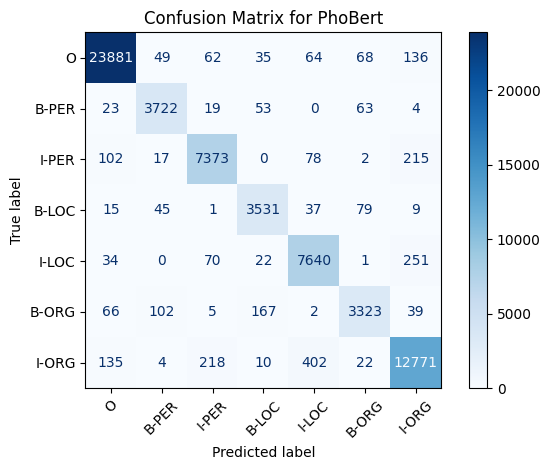

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from seqeval.metrics import classification_report
from sklearn import metrics

import matplotlib.pyplot as plt

# Flatten chuỗi
flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in true_preds for label in seq]

# Lấy tất cả nhãn có trong test
labels=["O","B-PER","I-PER","B-LOC","I-LOC","B-ORG","I-ORG"]

print(classification_report(
    true_labels, true_preds,
    digits=4
))


print(metrics.classification_report(
    flat_true,
    flat_pred,
    digits=4
))


cm = confusion_matrix(flat_true, flat_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(12, 12))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for PhoBert")
plt.tight_layout()
plt.savefig("confusion_matrix_phobert.png")
plt.show()

# **Phân tích kết quả sai**

In [70]:
preds = true_preds.copy()
labels = true_labels.copy()
indices = []
for i, (p, l) in enumerate(zip(preds, labels)):
    if p != l:
        indices.append(i)  
print(float(len(indices)/len(test_sentences)))
print("Số câu sai: ", len(indices))

0.0925
Số câu sai:  925


In [75]:
np.random.seed(42)
chosen = np.random.choice(indices, 50)
for c in chosen:
    print("Sent:   ", " ".join(test_sentences[c]))
    print("Tokens: ", test_sentences[c])
    print("Labels: ", ", ".join(labels[c]))
    print("Preds:  ", ", ".join(preds[c]))
    print("="*50)

Sent:    Lời phát biểu `` Tôi ''
Tokens:  ['Lời', 'phát', 'biểu', '``', 'Tôi', "''"]
Labels:  B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG
Preds:   O, O, O, O, O, O
Sent:    Vườn quốc gia Quần đảo Haparanda
Tokens:  ['Vườn', 'quốc', 'gia', 'Quần', 'đảo', 'Haparanda']
Labels:  B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG
Preds:   B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC
Sent:    ''Imagine '' ( album ) , album solo thứ hai của John Lennon .
Tokens:  ["''Imagine", "''", '(', 'album', ')', ',', 'album', 'solo', 'thứ', 'hai', 'của', 'John', 'Lennon', '.']
Labels:  B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, O, O, O, B-PER, I-PER, O
Preds:   O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O
Sent:    Vũ Thị Hương '' ( điền kinh ) ( 100m nữ ) ''
Tokens:  ['Vũ', 'Thị', 'Hương', "''", '(', 'điền', 'kinh', ')', '(', '100m', 'nữ', ')', "''"]
Labels:  B-PER, I-PER, I-PER, O, O, B-ORG, I-ORG, O, O, O, O, O, O
Preds:   B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O
Sent:    === Các vua của Śailendra ===
To